
**This code is replication of Kim&Nelson (1998)**
---



---
**Brief introduction of the code:**\
This is a Bayesian algorithm with three main blocks: \
1. Kalman filter
2. Hamilton(1989) basic filter
3. Estiamting parameters by multi-move Gibbs sampling.

We iteratively run the process 1→2→3→1→2→3→1…

---



---


From the algorithm, we can generate:
1. a new economic index of US
2. historical recession period of US
3.In the end, we will also display the distribution of all the parameters.

---

---


**Data**\
For column 1:4, they are component variables $\Delta y_i, i=1,2,3,4$ applied to generate original CLI.\
Column 5:8,9:12 are component variables with 1 lag and 2 lags individually:$\Delta y_{i_{t-1}} \& \ \Delta y_{i_{t-2}}, i=1,2,3,4$.

All data imported have been detrended.


Data source: The conference board

---



---


In [160]:
# import data
import os
import pandas as pd
import numpy as np
url = 'https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kndata4.csv'
print('From URL:', url)
kalpre1 = pd.read_csv(url, header=None, encoding='utf-8')

From URL: https://raw.githubusercontent.com/Buchunwang/UK-CLI/main/Kalman%20filter/kndata4.csv


**Functions**

---


There are 4 functions we are going to use:
1.  Kalman Filter (regime-switching state-space Kalman filter)
2.  Update process after Kalman filter using t+1 data for time t
2.  Posterior normal distribution
3.  Posterior inverse Gamma distribution


In [161]:
# Functions

import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings


# 1. Kalman filter (regime-switching)
# Compared with common Kalman filter, there is one extra state-dependent term 
def Kalman(R,H,A,Q_kal,true5D,Mu_st,N,P,K):
    k = 0
    for t in range(N-1):
        k += 1
        x[:, k] = np.dot(A, x[:, k-1])+Mu_st[:,k]    # Kalman equation 1
        P = np.dot(A, np.dot(P, A.T)) +Q_kal #np.dot(B,np.dot(Q,B.T))  # Kalman equation 2
        K = np.dot(P, np.dot(H.T, np.linalg.inv(np.dot(H, np.dot(P, H.T)) + R)))  # Kalman equation 3
        z[:, k] = [true4D[0, k], true4D[1, k], true4D[2, k], true4D[3, k]]
        x[:, k] = x[:, k] + np.dot(K, (z[:, k] - np.dot(H, x[:, k])))  # Kalman equation 4
        P = np.dot((np.eye(P.shape[0]) - np.dot(K, H)), P)  # Kalman equation 5
        vct[0, k] = P[0, 0]  # save variance of delta_ct
      #  vct[1, k] = P[1, 1] we won't use second and third row
       # vct[2, k] = P[2, 2]
    return K, x, vct

# 2. the process of adding t+1 data to the information set after running kalman filter
# From this process, we will obtain mean & variance of delta c_{t|t+1}
# The order of updating is from back to front, using data from T to update T-1 data,then update T-2...,3,2,1
def afterkal(x,vct,Q_kal,phi,c):# add t+1 data to information set
    for ii in range(N-2):  # this loop is just for xi_t and V_t conditional on delta_ct+1 for t=1,2,...,T-1
        eta = c - phi[0]*x[0, N-ii-2] - phi[1]*x[0, N-ii-3] - phimu_st[N-ii-1]  # value of eta_t two lag in my model, that's why I have term -phi(2)*x(2,N-i)
        Rt = phi[0]**2*vct[0, N-ii-2]+phi[1]**2*vct[0,N-ii-3]+var_vt
        xi[0, N-ii-2] = x[0, N-ii-2] + (phi[0]*vct[0, N-ii-2]+phi[1]*vct[0,N-ii-3])*eta/Rt
    # we only use first row of the mean and variance vector
    # so I calculated the first element of each mean & variance directly
        V[0, N-ii-2] = vct[0, N-ii-2] - (phi[0]**2 * (vct[0,N-ii-2]**2)+phi[1]**2*(vct[0,N-ii-3]**2)) / Rt
        c = normal(xi[0, N-ii-2], np.sqrt(V[0, N-ii-2]))
    # We only updated data from 1 to T-1,
    # mean & variance of delta c_T didn't get updated, it's still data generated from Kalman filter
    V[0, N-1] = vct[0, N-1]# V_T didn't get upgraded, it's still from step 1
    xi[0, N-1] = x[0, N-1]# xi_T didn't get upgraded, it's still from step 1
    return xi,V

# 3. calculating posterior mean & variance for normal distribution
def posteriornormal(mean,var,a,b):
    # input mean & variance are priors, they are fixed during the whole process
    
    # if mean & variance are scalar:
    if np.isscalar(mean) and np.isscalar(var):
        mean = 1/(1/var+a) * (mean/var + b )
        var  = 1/(1/var+a)
    
    #if mean & variance are matrix
    else:
        mean = np.linalg.inv(np.linalg.inv(var)+a) @ (np.linalg.inv(var) @ mean + b )
        var  = np.linalg.inv(np.linalg.inv(var)+a)
    if np.isnan(mean).any(): # if NaN shows up,reset to initial value
        mean = np.zeros(mean.shape)
        var = np.eye(var.shape[0])
    return mean, var



# generating random sample for posterior inverse gamma distribution
def posteriorIG(a,b): 
    #input a,b here are posterior values, priors of sigma_i are all IG(0,0) here
    sig=1 / np.random.gamma(a, 1/b)
    return(sig)



---


**Modeling of the algorithm**

---

1.
\begin{equation}
\Delta Y_{it}=\lambda_i(L)\Delta C_t+D_i+e_{it} \ \ \ i=1,2,3,4,5 \ \ \ t=1,2… T
\end{equation}
$Y_{it}$ are component series above except passenger car registrations,$C_t$ is the growth rate of CLI,
$\lambda _i(L)=\lambda _i $ for $i=1,2,3$, $\lambda _i(L)=\lambda _{i0}+\lambda _{i1}*L+\lambda _{i2}*L^2+\lambda _{i3}*L^3$ for $i=4$.






2.

\begin{equation}
\Psi_i(L)e_{it}=\epsilon_{it},  \ \ \ \epsilon_{it}\sim iid N(0,\sigma_i^2)	  
\end{equation}
where $\Psi_i(L)=1-\psi_{i1}L-\psi_{i2}L^2$, $L$ is the lag operator

3.
\begin{equation}
\Phi(L)(\Delta C_t-\mu_{s_t}-\delta
)=v_t\ \ \ \ \ \ \ \ \ \ v_t\sim iid N(0,σ^2_{vt})
\end{equation}
where $\Phi(L)=1-\phi_1L-\phi_2L^2$. $\mu_{s_t}-\delta$ is the mean growth rate of $\Delta C_t$, $\mu_{s_t}$ is the regime-switching component.



4.

\begin{equation}
	\mu_{s_t}=\mu_0+\mu_1S_t
\end{equation}
where $S_t=\{\begin{matrix}
		0,1
	\end{matrix}\}$
 and $\mu_1<0$.
The regime-switching happens at the mean value of $\Delta C_t$.


In [165]:
##########################################################################
#          pre-setting
##########################################################################
import numpy as np
from scipy.stats import norm, gamma, beta
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from numpy.random import normal
import pandas as pd
import warnings

# Remove warning message of time series from each iteration
def custom_warning_handler(*args, **kwargs):
    pass

warnings.showwarning = custom_warning_handler

##########################################################################
#          iteration setting
##########################################################################
iter = 10000 # number of iterations
burn = 2000 #we burn the first 2000 iterations and sampling from the later 8000 iterations in the MCMC
# If we find the samples still can't converge after 2000 iterations,
# burn and whole iteration number can be modified.
# Another common choice is iteration 20000 times and burn the first 10000 iterations.

# A higher number of burns would make the results more stable & convincing
# but it would also make the program much slower

##########################################################################
#          input data
##########################################################################
delta_y_mean = np.zeros((4,1))
for i in range(4):
    delta_y_mean[i,0] = np.mean(kalpre1.iloc[:, i]) #mean value of Y_it 
    # This will be used in generating delta in appendix 7

kalpre=kalpre1.values
np.random.seed(198011) #fix randomness
N = kalpre.shape[0] #length of input
Y = np.transpose(kalpre[:,0:4])#Y_{1t} to Y_{4t}
# Calculate delta_y, delta_y_t-1, and delta_y_t-2
# delta y_it=Yit-E(Y), remove the mean value
y = np.zeros((4, N))
y1lag = np.zeros((4, N))
y2lag = np.zeros((4, N))

for i in range(4):
    y[i, :] = kalpre[:, i ].T-np.mean(kalpre[:, i ])
    y1lag[i, :] = kalpre[:, i + 4].T-np.mean(kalpre[:, i+4 ])
    y2lag[i, :] = kalpre[:, i + 8].T-np.mean(kalpre[:, i+8 ])


##########################################################################
# storage space for kalman filter output
##########################################################################
x = np.zeros((3, N))#empty matrix to save mean value of xi_t
xi=np.zeros((1,N))# mean of delta c_{t|t+1}
V=np.zeros((1,N)) # variance of delta c_{t|t+1}
mu_st=np.zeros(N) #regime-switching element mu_st 
phimu_st=np.zeros(N) #regime-switching element with lags for kalman filter: phi(L)*mu_st,
                     # phimu_st is input for Kalman filter equation 1

# noise matrix Q_kal, correpodent with vector u^*_t=[var_vt 0 0 0 0 0]'
var_vt=1 # iid variance in equation (3), vt~iid N(0,1)
# scale of new economic index is up to the choice of v_t's variance
Q_kal = np.zeros((6,6))
Q_kal[0,0]=var_vt #Q in kalman filter, process noise
new_delta_ct= np.zeros((N, 1)) # delta c_{t|t+1} 

##########################################################################
# Gibbs sampling
##########################################################################

Nn=kalpre.shape[0]-2 #length of input 
rrighta3 = np.zeros((1, Nn - 2))#this matrix is for calculating posterior distribution of lamda
Q = np.zeros((Nn - 4, 2))
Qstar = np.zeros((Nn - 4, 2))
fvarphi = np.array([[1, 0], [0, 1]])
mut = np.zeros(Nn)# mu_st used generating posterior distribution of phi, data length N-2 

meanlamda=np.zeros(4)
varlamda=np.zeros(4)
lamda=np.zeros(4)
sig=np.zeros(4)
vvarpsi=np.zeros((2,4))
mmeanpsi=np.zeros((2,4))

# Input for gibbs sampling
inputkal1 = np.full((Nn,7), np.nan)
# Fill the columns 4 to 7 with the data y_it, i=1,2,3,4
inputkal1[:,3:7] = (y[:,2:N+2]).T
# name of each column: 1. delta c_t, 2. delta c_t-1 3. delta c_t-2 thses will be updated every iteration
                    #  4 to 7: delta y_it, i=1,2,3,4


##########################################################################
# user-choose prior
##########################################################################

# variance and mean prior
varlamda4p = np.eye(4) #prior for lamda_4,41,42,43
meanlamda4p = np.array([[0],[0],[0],[0]])
varlamdap=1 # prior for lamda_1,2,3
meanlamdap=0
varpsip = np.eye(2)
meanpsip = np.zeros((2, 1))
sig_a=(Nn-2)/2 #when calculating sigma, length of applied series is Nn-2 for i=1,2,3
#for i=4, length of input data is N-5, this will be set in the itertaion independently
#sigma_1~IG(sig1a,sig1b) inverse gamma distribution
# prior is IG(0,0), 
#because posterior is a fixed number :prior+T/2 which is just T/2, so we just set sig_i_a as (Nn-2)/2 here
                                    # T is the lenth of input series, here the length is Nn-2
# if want different prior such as m, let sig1a=...=sig5a=m+T/2
varmup=varphip = np.eye(2)
meanmup=meanphip = np.zeros((2,1))


##########################################################################
# form storage space
##########################################################################
#N=kalpre.shape[0]
# Output
# We set some empty matrices here to save values from each iteration
# After the 2000 burn-in period, we need to save value for later 80000 iterations

vlamda=np.zeros((iter-burn,7)) #lamda_1,2,3 lamda_4_{0,1,2,3}
mlamda=np.zeros((iter-burn,7))
bsig=np.zeros((iter-burn,4))
vpsi=np.zeros((iter-burn,8))
mpsi=np.zeros((iter-burn,8))
mphi=np.zeros((iter-burn,2))
vphi=np.zeros((iter-burn,2))
mmu=np.zeros((iter-burn,2))
vmu=np.zeros((iter-burn,2))
mmu1 = np.zeros(iter-burn) # sampling of mu0 is independent process, better to seperate
mmu2 = np.zeros(iter-burn)
vmu1 = np.zeros(iter-burn)
vmu2 = np.zeros(iter-burn)
delta=np.zeros(iter-burn)
transition_prob_p=np.zeros(iter-burn)
transition_prob_q=np.zeros(iter-burn)
delta=np.zeros(iter-burn)
regime=np.zeros((N-4, 1))
sample_ct=np.zeros((N, 1))






##########################################################################
# Initialization
##########################################################################
lamda=0.5*np.ones(3)#lamda_123
lamda4=np.zeros(4)
lamda4[0]=0.5
sig=0.2*np.ones(4)
phi=np.zeros(2)
psi=np.zeros((4,2))
mu0=-2
mu1=2.5

q = 0.9
p = 0.9

##################################  generate initial St based on transition probabilties p,q 
def generate_markov_chain(p, q, initial_state, N):
    # Initialize the Markov Chain
    markov_chain = np.zeros(N)
    markov_chain[0] = initial_state


    for i in range(1, N):
        if markov_chain[i-1] == 1:
            markov_chain[i] = np.random.choice([0, 1], p=[1-p, p])
        else:
            markov_chain[i] = np.random.choice([0, 1], p=[q, 1-q])

    return markov_chain
initial_state = 0  # initial state
St = generate_markov_chain(p, q, initial_state, N)
SSt=St
mu_st = mu0 * np.ones(N) + mu1 * np.ones(N) * St

phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
phimu_st = np.array(phimu_st)
phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
Mu_st=np.zeros((6,N))
Mu_st[0,:]=phimu_st



##############################################################################
# initial setting finishes here
##############################################################################

**Details of the algorithm**

---


---


---




In Gibbs sampling, we always use the most up-to-date information as input for each block of the Bayesian algorithm.

There are 3 main blocks: Kalman filter, Hamilton (1989) basic filter and paraeter estimation through multimove Gibbs sampling. We will introduce detail of each block and how to iteratively connect each block.


---


---


First step: Kalman filter\
input:
1.  parameters generated from last step's multimove Gibbd sampling
including $\Phi(L), \Psi_i(L), \mu_0,\mu_1,σ_i λ_i, i= 1,2,3,4,5$
2.  series $Δ y_{it}, i=1,2,3,4,5$

output: mean & variance of $Δ c_{t|t} , t=1, ⋯⋯, T-1, T$

Then we make use of t+1 data of $Δ c_{t|t}$ to update $Δ c_{t|t}$ based on Kalman filter equations

In the end of step 1: we get $Δ c_{t|t+1}$

---
\begin{equation}
	\Delta y^*_t=H^*\zeta_t+\epsilon_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}
which can be expanded as  

\begin{equation}
\begin{bmatrix}
	\Delta y^*_{1t}\\ \Delta y^*_{2t}\\ \Delta y^*_{3t}\\ \Delta y^*_{4t}
\end{bmatrix}
=\small\small \small
\begin{bmatrix}
	\lambda_1&  -\lambda_i\psi_{11}&-\lambda\psi_{12}&0&0&0\\
	\lambda_2& -\lambda_i\psi_{21}& -\lambda\psi_{22}&0&0&0\\
	\lambda_3& -\lambda_i\psi_{31}& -\lambda\psi_{32}&0&0&0\\
	\lambda_4&  -\lambda_4\psi_{41} + \lambda_{41}&\ \ -\lambda_4\psi_{42} - \lambda_{41}\psi_{41} + \lambda_{42}&\ \ -\lambda_{41}\psi_{42} - \lambda_{42}\psi_{41} + \lambda_{43}&\ \ -\lambda_{42}\psi_{42} - \lambda_{43}\psi_{41}&\ \ -\lambda_{43}\psi_{42}
\end{bmatrix}
\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2} \\ \Delta c_{t-3}\\ \Delta c_{t-4}\\ \Delta c_{t-5}
\end{bmatrix}
+
\begin{bmatrix}
	\epsilon_{1t}\\
	\epsilon_{2t}\\
	\epsilon_{3t}\\
	\epsilon_{4t}
\end{bmatrix}
\end{equation}
\begin{equation}
	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2}\\ \Delta c_{t-3} \\ \Delta c_{t-4} \\ \Delta c_{t-5}
	\end{bmatrix}
	=
	\begin{bmatrix}
		\Phi(L)\mu_{s_t}\\
		0\\0\\0\\0\\
		0
	\end{bmatrix}
	+\begin{bmatrix}
		\phi_1 & \phi_2 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 
	\end{bmatrix}
	\begin{bmatrix}
	\Delta c_{t-1}\\ \Delta c_{t-2} \\ \Delta c_{t-3}\\ \Delta c_{t-4} \\ \Delta c_{t-5} \\ \Delta c_{t-6}
	\end{bmatrix}
	+
	\begin{bmatrix}
		v_t\\ 0 \\ 0\\ 0 \\ 0\\ 0 
	\end{bmatrix}
\end{equation}

Before starting Kalman filter, we form all the matrix above. Also, $Δ y^*_{it}=\Psi_i(L)*Δ y_{it}$, we use new $\Psi_i(L)$ estimated from last iteration to form new $Δ y^*_{it}$ at the beginning of Kalman filter in every iteration.

---



The function of Kalman filter is to estimate mean and variance of $\zeta_t$, $\zeta_t=	\begin{bmatrix}
\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2} \\ \Delta c_{t-3} \\ \Delta c_{t-4} \\ \Delta c_{t-5}
	\end{bmatrix} $.  

Algorithm of Kalman filter is show as follows

t iterates from t=2 to t=T

For each iteration t, we use t-1 as input. $\zeta_{t|t}$ from last iteration would become $\zeta_{t-1|t-1}$ for next iteration. $P_{t|t}$ from last iteration would become $P_{t-1|t-1}$ for next iteration.

1.
\begin{equation}
 \zeta_{t|t-1}=F^*\zeta_{t-1|t-1}+\tilde M^*_{s_t}
 \end{equation}
 Equation 1 is the process of **predicting** mean value of $\zeta_t $ from $\zeta_{t-1}$.  $\  \zeta_{t|t-1}=E[\zeta_t|t-1]=E[F*\zeta_{t-1}+\phi(L)\mu_{st}+v_t|t-1]=F*\zeta_{t-1}$ as $\mu_{st}$ is imposed mean zero in the setting according to Kim and Nelson (1998) and $v_t$ is iid noise of time t. For the first input $t=1$, we assume $\zeta_{1|1}=0$. This is extended version of normal state-space Kalman filter as we added state-dependent element $M_{st}$ in the first kalman filter equation.
   
2.
 \begin{equation}
 P_{t|t-1}=F^*P_{t-1|t-1}F^{*^T}+Q
 \end{equation}
 Equation 2 is the process of **predicting** variance of $\zeta_t $ from $\zeta_{t-1}$. $Q$ is the variance matrix of process noise $[v_t,\ v_{t-1},\ 0]'$.  

 3.
\begin{equation}
	K(t)= P_{t|t-1}H^{*^T}[H^*P_{t|t-1}H^{*^T}+R]^{-1}      
\end{equation}
Equation 3 is the process of **filtering** or upgrading. Through this equation we can obtain the value of Kalman gain $K$. Kalman gain would stablize after a few iterations (which is called as steady-state Kalman gain). This is caused by the stablized variance matrix $P$ after a few iterations.
  

4.
\begin{equation}
 \zeta_{t|t}= \zeta_{t|t-1}+K(t)([\Delta y^*_t-H^*\zeta_{t|t-1}]
\end{equation}
Equation 4 is the process of **filtering** mean value of $\zeta_t$ by adding the filtered error term at time t.
  

5.
\begin{equation}
	P_{t|t}=[I-K(t)H^*]P_{t|t-1}
\end{equation}
where $I$ is identity matrix.  
Equation 5 is the process of **filtering** variance of $\zeta_t$. $P$ would stablize with the stablization of Kalman gain after a few iterations.
  

---


We iteratively run the algorithm from equation 1 to 5 from $t=2$ to $t=N$ and in the end we would obtain the filtered mean and variance of $Δ c_{t|t}$ for $t=1\dots N$ from each iteration.

After Kalman filter, we make full use of the information to improve the estimation result of Kalman filter.

 Take $\Delta\ c_{t+1}$ as observation and run a backward iteration to improve the effect of estimation.

---

We take $\Delta c_{t+1}$ as extra observation and add  it to information set to lower the variance based on the following equation:
\begin{equation}
	p(\tilde{\zeta}_T|\Delta\tilde{y}^*_T)=p(\zeta_T|\Delta\tilde{y}^*_T)\mathop{\Pi}\limits^{T-1}_{t=1}p(\zeta _t|\Delta\tilde{y}^*_t,\zeta _{t+1})
\end{equation}
where joint distribution $\tilde{\zeta}_T=[\begin{matrix}
	\zeta_1 &\zeta_2& \cdots &\zeta_T
\end{matrix}]$' and $\tilde{y}_T=[\begin{matrix}
	y_1 &y_2& \cdots &y_T
\end{matrix}]$'.
\\ From last step, $\zeta _{t|t}$ and $V_{t|t}$ is obtained and we generated $\Delta c_T$. In this step, $\Delta c_t$ for $t=1,2,\cdots T-1$ is what we are going to generate. We follow \citet{kim} and chapter 13 of \citet{ham2}, the updating equations of adding $\Delta c_{t+1}$ into information set are:  

\begin{equation}
	\zeta_{t|t,\Delta c_{t+1}}=\zeta_{t|t}+V_{t|t}F^*(1)\eta_t/R_t
\end{equation}  

\begin{equation}
	V_{t|t,\Delta c_{t+1}}=V_{t|t}-V_{t|t}F^*(1)F^*(1)'V_{t|t}'/R_t
\end{equation}  

where $\eta_t=\Delta c_{t+1}-\Phi(L)\mu_{t+1}-F^*(1)\zeta_{t|t}$ and $E_t=F^*(1)V_{t|t}F^*(1)'+var[u^*_{t+1}(1)]$. $F^*(1)$ and $u^*_{t+1}(1)$ are first row of $F^*$ and $u^*_{t+1}$.
  
  With the new mean $\zeta_{t|t,\Delta c_{t+1}}$ and variance $V_{t|t,\Delta c_{t+1}}$ conditional on $\Delta c_{t+1}$, we can generate $\Delta c_t$ for $t=1,2,\cdots T-1$, we have also got $\Delta c_T$ from last step. In the end, we get $\Delta c_{t|t+1}$ for $t=1,2,\cdots T$



---

---

 **Second step: Hamilton (1989) basic filter**

Here we applied MarkovAutoregression package in python. There is prepared Hamilton filter inside the package.
We could also use Markovregression package which will be 10 times faster but we will miss many small recessions if we choose this package. It's fast but not informative.

Input: series $Δ c_{t|t+1}$ from Kalman filter




Setting of Hamilton filter:
1.  regime number:2
2.  order of autoregression:4 (this could be different for different data) If we don't set order of autoregression properly, there could be two consequences: 1. improper etimation regime probabilities 2. the worst case is that hamilton filter would collapse (happened in actual tests). Hamilton filter can't generate regime probabilties (or just P(recession_t) is a stochastic process around 0.5, meaningless estiamtion. For UK data, order=2 is the appropriate choice.

 
Output:
1. regime probabilities of recession & expansion at each time t
2. steady state transition probabilities between regimes
3. regime series (if at time t, $P(recession)>P(expansion), S_t=0,$ otherwise $S_t=1$


Hamilton(1989) basic filter is critial part for this 'regime-switching' algorithm as it exposes the recession/expansion information from input data.

One thing needs extra attention is that Hamilton(1989) basic filter can't handle extreme values. The program would collapse if extreme value shows up. There are a few things we can do if this happens.
1.  Modify regime numbers. We can try giving extreme situation another indepednt regime. For example, current nodel here uses 2-regime setting, we could try 3 regimes.
2.  Apply smoothers to the input data
3.  Romove the most unstable data period (such as 2020 recession in UK data test). But this may not be an appropriate choice for study of originally unstable stuff such as volatilities.
4.  Remove the process of using t+1 data after kalman filter. This process would make the input $\Delta c_t$ more informative but this process can also lead to the existence of extreme values at the same time. Extreme value could cause the collapse of Hamilton (1989) basic filter.

Some extra setting after the Hamilton filter: as we set autoregression order=4, there are only N-4 data as output. The 4 missing data point at the beggining of series, we set them all as 1 according to kim's code. So the output St series are: [1,1,1,1, St]\
Would this affect estimation results? Very small influence. 1. For parameter estimation after hamilton filter, we use N-2 data, so only first 2 data are affected by our setting. 2. For Kalman filter, prediction and filtering part of Kalman filter is not accurate at the beginning part, the variance would stablize at around t=10. What's more, after running the code for the first time, we can modify the frist 4 St according to the estimation result of the model (such as [1 0 0 0 St] or [0 1 1 0 St], this would minimize the negative influence.


---

---

**Third step: parameter estimation**

input: $Δ y_{it}$, $Δ c_t$, $S_t$, prior distribution of each parameter

output: posterior distribution of each parameter.

---
Prior distributions for each parameter stay fixed during the process of MCMC.

The equation of posterior distribution is calculated through MLE.

In each calclulation of posterior distribution, we always use the most up-to-date copy of input.

---




 Generating $\lambda _i$, $i=1,2,3,4$
Given $\tilde{S}_T=\begin{bmatrix}
	S_1& S_2 &\cdots&S_T
\end{bmatrix}'$ from last step and $\tilde{c}_T=\begin{bmatrix}
	c_1& c_2 &\cdots&c_T
\end{bmatrix}'$.

\begin{equation}
	y^*_{it}=\lambda_i\Delta c_t^*+\epsilon _{it}
\end{equation}
where $\Delta c^*_t=\Psi_i(L)\Delta c_t$ and $\Delta y^*_t=\Psi_i(L)\Delta y_t$. $Ψ_i(L)$ we use in one iteration is the most up-to-date sample generated from last iteration. Define $\Delta \tilde{C}^*$ and $\Delta \tilde{y}^*_i$ as variable vectors of right-hand-side and left-hand-side individually. We can then generate posterior distribution $\lambda_i$ by:


$$
\lambda_i \sim N\left(\left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{C}^{\ast} + X_i^{-1}\right)^{-1}\left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{y}_i^{\ast} + X_i^{-1} x_i\right), \left(\sigma_i^{-2} \Delta\tilde{C}^{\prime} \Delta\tilde{C}^{\ast} + X_i^{-1}\right)^{-1}\right)
$$

given prior distribution as
\begin{equation}
	\lambda_i\sim N(x_i,X_i)
\end{equation}

$σ_i$ used in current iteration is sample generated from last itereation. prior mean $x_i$ is fixed as 0 and prior variance $X_i$ is fixed as 1 for i=1,2,3. prior of $\lambda_4$ is fixed as $x_i=\begin{bmatrix}
0 \\ 0 \\ 0 \\0 \end{bmatrix}$, $X_i=\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 \\
\end{bmatrix}$ 
When drawing random samples for $\lambda_4$, we should use multivariate normal. If we use univariate normal (only use diagonal term in covariance to run the np.random.normal() code), this could cause quite different results if the covariance is strong. 
 
---


 Generating $\psi$ and $\sigma_i$, $i=1,2,3,4$
Let $Z_t=y_{it}-\lambda _i \Delta c_t=e_{it}$ where $\lambda _i$ is newly generated from last step.

\begin{equation}
	\Psi(L)Z_t=\epsilon_{it}
\end{equation}

\begin{equation}
	Z_t=\psi_{i1}Z_{t-1}+\psi_{i2}Z_{t-2}+\epsilon_{it}
\end{equation}

Define $\Delta \tilde{Z}$ and $\tilde{X}$ as variable vectors of right-hand-side and left-hand-side individually. We can then generate posterior distribution $\tilde\Psi_i$ ($\tilde\Psi_i=\begin{bmatrix}
	\psi_{i1}&\psi_{i2}
\end{bmatrix}'$) by:
$$
\tilde{\Psi}_i \sim N\left(\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{X}^{\ast} + \Pi_i^{-1}\right)^{-1}\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{Z}_i^{\ast} + \Pi_i^{-1} \pi_i\right),\left(\sigma_i^{-2} \tilde{X}^{\prime} \tilde{X}^{\ast} + \Pi_i^{-1}\right)^{-1}\right)
$$

given prior distribution as

\begin{equation}
	\lambda_i\sim N(\pi _i, \Pi _i)
\end{equation}

$\pi_i$ is fixed as $\begin{bmatrix}
0 \\ 0 \end{bmatrix}$ and $\Pi_i $ is fixed as $\begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix}$ for $i=1,2,3,4$


With new $\tilde\Psi_i$ from above,

\begin{equation}
	\sigma^2_i\sim IG(\frac{a+T}{2},\frac{b}{2}+\frac{1}{2}(\tilde Z-\tilde X\tilde \Psi_i)'(\tilde Z-\tilde X\tilde \Psi_i))
\end{equation}

given prior $$\sigma^2 \sim IG(\frac{a}{2},\frac{b}{2})$$
where $IG$ means inverse gamma distribution. $a$ and $b$ are known value and we follow Kim & Nelson (1998) to set $a=b=0$.

In the programming, if we choose to use gamma to generate random sample, the function should be 1/IG(a1,/1/b1) for $\sigma^2\sim IG(a1,b1)$ or we can directly use inverse gamma function from the scipy package, code is invgamma.rvs(a,b).

---


 Generating $\mu_0$, $\mu_1$ and $\tilde \phi$
 To generate
$\tilde\phi=\begin{bmatrix}\phi_1&\phi_2\end{bmatrix}'$, let $G_t=\Delta c_t-\mu_{s_t}$.

\begin{equation}
	G_t=\phi_1G_{t-1}+\phi_2G_{t-2}+v_t
\end{equation}
let $\tilde Q$ and $\tilde G$ be right-hand-side and left-hand-side variable vector individually.
We can generate posterior distribution of $\Phi$.

\begin{equation}
	\tilde \Phi\sim N((\tilde Q'\tilde Q+X^{-1})^{-1}(\tilde Q'\tilde G+X^{-1}x),(\tilde Q'\tilde Q+X^{-1})^{-1})
\end{equation}
given prior as

\begin{equation}
	\Phi\sim N(x,X)
\end{equation}
With new $\Phi$ above, we let $G^*=\Delta c_t-\phi_1\Delta c_{t-1}-\phi_2\Delta c_{t-2}$, then we can get


\begin{equation}
	G^*=\mu_0^*+\mu_1(S_t-\phi_1S_{t-1}-\phi_2S_{t-2})+v_t
\end{equation}

where $\mu_0^*=\mu_0(1-\phi_1-\phi_2)$. Let $\tilde Q^*$ and $\tilde G^*$ be right-hand-side and left-hand-side variable vector individually. Posterior distribution of $\tilde \mu=\begin{bmatrix}
	\mu_0^*&\mu_t
\end{bmatrix}$ from.

$$
\tilde{\mu} \sim N\left(\left(\tilde{Q}^{\ast\prime}\tilde{Q}^{\ast} + X^{*^{-1}}\right)^{-1}\left(\tilde{Q}^{\ast\prime}\tilde{G}^{\ast} + X^{*^{-1}}x^{\ast}\right), \left(\tilde{Q}^{\ast\prime}\tilde{Q}^{\ast} + X^{*^{-1}}\right)^{-1}\right)_{I(\mu_1>0)}
$$

given prior as
\begin{equation}
	\mu\sim N(x^*,X^*)
\end{equation}

$x^*_i$ is fixed as $\begin{bmatrix}
0 \\ 0 \end{bmatrix}$ and $X^*$ is fixed as $\begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix}$

Attention:
1. $\mu_1$ has to be greater than 0, as state 1 represents expansion regime, there should be an positive deviation from the mean growth rate of economic index. if $ \mu_1<0 $, redo the sampling again until we generate a posive $\mu_1$ from posterior normal distribution of $\mu$.

2.  The genrated mean & variance of $\mu_0^*$ is the mean and variance of $\mu_0*(1-\phi_1-\phi_2)$. In order to generate $\mu_0$ we generate a sample from the distribution of $\mu_0^*$, then we divided the sample $\mu_0=\frac{\mu_0^*} {1-\phi_1-\phi_2}$.


---

---
Generate δ
Based on  equation 10 and 11 in K&N(1998), we run the Kalman filter again to generate steady-state Kalman gain $K^*$, then we use the steady-state Kalman gain to generate $\delta$: \begin{equation*}
δ=E_1'[I_k-(I_k-K^*H)F]^{-1}K^*Δ \overline{Y}
\end{equation*}
(There was a typo in the equation in Kim's paper, The first $K_k$ in paper (in equation A.27) is actually $I_k$ according to Kim's GAUSS code and original calculation in Stock and Watson (1991).
k is the dimension of F,  $\ Δ \overline{Y}=\begin{bmatrix} Δ \overline{Y_1}&Δ \overline{Y_2}&Δ \overline{Y_3}&Δ \overline{Y_4}&Δ \overline{Y_5}\end{bmatrix}' $.
Difference with former Kalman filter above: here we used $Δ y_i=λ(L)*Δ c_t+e_{it}$
rather than $\Psi(L)Δ y_i=λ(L)\Psi(L)Δ c_t+\epsilon_{it}$ and $e_{it}$ would also need to be estimated because $e_{it}$ is not a iid noise, we can't treat it like one and put it into the covariance matrix. So in actual programming, the covariance matrix R (which is correpodent with $\epsilon_t$) will be a $4*4$ zero-matrix (it was a $4*4$ diagonal matrix with $\sigma_i^2$ at the diagonals in former Kalman filter).
\begin{equation}
	\Delta y^*_t=H^*\zeta_t
\end{equation}
\begin{equation}
	\zeta_t=\tilde M^*_{s_t}+F^*\zeta_{t-1}+u^*_t
\end{equation}

Where 

$\zeta_t=\begin{bmatrix}
	\Delta c_t\\ \Delta c_{t-1} \\ \Delta c_{t-2} \\ \Delta c_{t-3}\\ e_{1,t-1} \\ e_{1,t-2}\\ e_{2,t-1} \\ e_{2,t-2}\\ e_{3,t-1} \\ e_{3,t-2}\\ e_{4,t-1} \\ e_{4,t-2}
\end{bmatrix}
$ 
$u^*_t=\begin{bmatrix}
    v_t \\ 0 \\ 0 \\ 0 \\ \epsilon_{1t}\\ 0\\ \epsilon_{2t}\\ 0\\ \epsilon_{3t}\\ 0\\ \epsilon_{4t}\\ 0\\
\end{bmatrix} 
$
$
\tilde M^*_{s_t}=\begin{bmatrix}
    \Phi(L)*\mu_{st} \\ 0 \\ 0 \\ 0 \\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\
\end{bmatrix}
$
$
F^* = \begin{bmatrix}
\phi_1 & \phi_2 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & \psi_{11} & \psi_{12} & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & \psi_{21} & \psi_{22} & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{31} & \psi_{32} & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \psi_{41} & \psi_{42} \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\
\end{bmatrix}
$
$H^* = \begin{bmatrix}
\lambda_1 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\lambda_2 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\
\lambda_3 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
\lambda_4 & \lambda_{41} & \lambda_{42} & \lambda_{43} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\
\end{bmatrix}
$

By running Kalman filter for this setting, we want to calculate only one value: steady-state Kalman gain. Kalman gain is generated from Kalman filter equation 3 ($K (t)= P_{t|t-1}H^{*^T}[H^*P_{t|t-1}H^{*^T}+R]^{-1}   $) and value of K will stablize after a few iterations. So if we want to gain steady-state Kalman Gain, we can directly take the Kalman gain from the final iteration.

---
Generate new economic index $C_t$

After obtaining $\delta$ and $\Delta c_t$, We can generate the final economic index by following the equation $C_t=\Delta c_t+C_{t-1}+\delta$, $t=1,2,\cdots , T$. We need value $C_0$ to start iteratively generating $C_t$, but the chocie of $C_0$ can be arbitrary. We choose $C_0=40$ here as this will make it easier to have some comparison with original economic index. $C_0$ choice for UK data is 99.

Another thing needs extra comment is: the trend of new economic index

The trend purely comes from the element $\delta$, we add one more $\delta$ every single time in $C_t=\Delta c_t+C_{t-1}+\delta$. But scale of $\delta$ depends on the mean value of $Y_{it}$, $\delta$ could be very small and there will be almost no trend in the new economic index ( this happens for the UK data result).

In [166]:
##############################################################################
#Start iteration here
##############################################################################

for i in range(iter):

# First part of MCMC------- Kalman Filter

##############################


# Use the parameters from last iteration
# we need new A,R,H
    top_row = np.array([phi[0], phi[1], 0, 0, 0, 0])

# define the bottom part
    bottom_part = np.hstack((np.eye(5), np.zeros((5, 1))))

# stack them vertically
    A = np.vstack((top_row, bottom_part))
    R = np.diag(sig)
    H = np.zeros((4,6))
    for m in range(3):
      H[m,0]=lamda[m]
      H[m,1]=-lamda[m]*psi[m,0]
      H[m,2]=-lamda[m]*psi[m,1]
    H[3,:] = [                                       lamda4[0], #0 lag
                              - lamda4[0]*psi[3,0] + lamda4[1], #1 lag
          -lamda4[0]*psi[3,1] - lamda4[1]*psi[3,0] + lamda4[2], #2 lag
          -lamda4[1]*psi[3,1] - lamda4[2]*psi[3,0] + lamda4[3], #3 lag
          -lamda4[2]*psi[3,1] - lamda4[3]*psi[3,0],             #4 lag
          -lamda4[3]*psi[3,1]]                                  #5 lag


# all lamda and psi come from random sampling from last iteration
    H = np.squeeze(H)
# form phi(L)*mu_st
    phimu_st=np.zeros(N)
    phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
    phimu_st = np.array(phimu_st)
    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])
    Mu_st=np.zeros((6,N))
    Mu_st[0,:]=phimu_st
    P = 0.1*np.eye(6)# initial setting of variance matrix of xi_t, it will be updated in the Kalman filter 
    x = np.zeros((6, N))#empty matrix to save mean value of xi_t
    vct = np.zeros((6, N))#empty matrix to save variance of xi_t
# Construct delta_y* using new psi
    ystar = y.T - psi[:, 0].T* y1lag[0:4, :].T- psi[:, 1].T*y2lag[0:4, :].T # delta y* = Psi(L)*y_it
    true4D = ystar.T
    K=np.zeros(H.T.shape)
# run Kalman filter
    K,x,vct=Kalman(R,H,A,Q_kal,true4D,Mu_st,N,P,K)
# generate delta_c_T, the final data point T    
    c = normal(x[0, N-1], np.sqrt(vct[0, N-1]))  
# add t+1 data to information set
    xi, V= afterkal(x,vct,Q_kal,phi,c) # mean and variance of delta c_{t|t+1}

########################
# generate new delta_ct based on new mean and variance
    for iii in range(0, N):
        new_delta_ct[iii] = np.mean(normal(xi[0,iii], np.sqrt(V[0,iii]),1000)) # new delta_c_t


##############################################################
############# Second step of MCMC-------- Hamilton (1989) basic filter


# Use output from Kalman filter to generate regime probability then generate St
    data= new_delta_ct.flatten() # the only input for Hamilton filter
# Create date range
    date_range = pd.date_range(start='1959-09', end='1995-01', freq='M')
# Create DataFrame with date range and data
    df = pd.DataFrame({'date': date_range, 'delta_ct': data})
    df.set_index('date', inplace=True)

    mod = sm.tsa.MarkovAutoregression(
        df['delta_ct'], k_regimes=2, trend="n", order=4, switching_variance=True
)
    res = mod.fit()
# standard is not fixed, for some US recession signal, standard is >0.4
    St = (res.smoothed_marginal_probabilities[1] < 0.5).astype(int)
    SSt = St.reset_index(drop=True)
    SSt = np.concatenate(([1,1,1,1], SSt))#new St
    St=SSt[2:N].reshape(-1,1)
    # SSt will be set back to St at the start of next iteration for kalman filter

###########################################################################
############# Third step of MCMC-------- Gibbs sampling
# Input: St & inputkal1 (delta c_t and delta y_it)
# St is ready, we now prepare inputkal1


# Fill the first three columns with t, t-1, t-2 data from 'new_delta_ct' from each iteration
    for iiii in range(3):
        inputkal1[:, iiii] = new_delta_ct[2 - iiii:N - iiii].flatten()   # N-2 values
# data length for code below is Nn, (Nn=N-2) 

# Section 1
# posterior distribution of lamda
# generate lamda_1,2,3
    righta3 = inputkal1[:, 0].T
    for m in range(3):
      ys=(inputkal1[2:Nn, 3+m] - inputkal1[1:Nn-1, 3+m] * psi[m, 0] - inputkal1[0:Nn-2, 3+m] * psi[m,1]).reshape(-1,1) # Psi(L)*delta y_it
      rrighta=(righta3[2:Nn]- righta3[1:Nn-1] * psi[m, 0] - righta3[0:Nn-2] * psi[m,1]).reshape(-1, 1) # delta C^*~
      meanlamda[m], varlamda[m]= posteriornormal(meanlamdap,varlamdap, rrighta.T@ rrighta/sig[m], rrighta.T@ys/sig[m])
      lamda[m]=np.random.normal(meanlamda[m], np.sqrt(varlamda[m]))
      if m==0:#print during the process to check convergence
          if i % 100 == 0:  # if the remainder of i divided by 100 is 0, it means i is a multiple of 100
              print("(delta C*~)'*(delta C*~) for lamda ",m+1,":",rrighta.T @ rrighta,"meanlamda1:", meanlamda[0])
            
#generate lamda4, lamda_41, lamda_42, lamda_43
    ys4 = (inputkal1[5:Nn, 6] - inputkal1[4:Nn-1, 6] * psi[3, 0] - inputkal1[3:Nn-2, 6] * psi[3,1]).reshape(-1, 1)
# lamda_4 has 3 lags
    for j in range(4):
        rrighta4[:,j] = (righta3[5-j:Nn-j]- righta3[4-j:Nn-j-1] * psi[3, 0] - righta3[3-j:Nn-j-2] * psi[3,1])
    meanlamda4, varlamda4= posteriornormal(meanlamda4p,varlamda4p, rrighta4.T@ rrighta4/sig[3], rrighta4.T@ys4/sig[3])
    vector_lamda4= np.random.multivariate_normal(meanlamda4.flatten(), varlamda4)
    for j in range(4):
        lamda4[j]=vector_lamda4[j]



# Section 2
# generate new psi & sigma
# same as above, i=1,2,3 first, then we will calculate Psi_i and sigma_i for i=4 later
    for m in range(3):
      Zpsi=inputkal1[:, 3+m] - inputkal1[:, 0] * lamda[m] #delta y_it-lamda_i*delta c_t
      Xpsi=np.column_stack((Zpsi[1:Nn - 1], Zpsi[:Nn - 2]))
      meanpsi, varpsi = posteriornormal(meanpsip,varpsip,Xpsi.T @ Xpsi / sig[m],(Xpsi.T @ Zpsi[2:Nn]).reshape(-1, 1) / sig[m])
      psi[m,:]=np.random.multivariate_normal(meanpsi.flatten(), varpsi) #psi_ij sample
      mmeanpsi[:,m]=meanpsi.flatten()   # mean and var sample of psi
      vvarpsi[:,m]=np.diag(varpsi).T
# generate sigma_i
      Xx=Xpsi*psi[m,:] 
      sig_b=0.5*np.dot(((Zpsi[2:Nn] - Xx[:, 0] - Xx[:, 1]).reshape(-1, 1)).T, (Zpsi[2:Nn] - Xx[:, 0] - Xx[:, 1]).reshape(-1, 1))
      sig[m]=posteriorIG(sig_a, sig_b) # random sample of sigma_i^2

# Psi_4 and sigma_4
    Zpsi4 = (inputkal1[3:Nn, 6]
          -inputkal1[3:Nn, 0] * lamda4[0]
          -inputkal1[2:Nn-1, 0] * lamda4[1]
          -inputkal1[1:Nn-2, 0] * lamda4[2]
          -inputkal1[0:Nn-3, 0] * lamda4[3]
         ) # delta y_4t- lamda_4(L)*delta c_t
    Xpsi4 = np.column_stack((Zpsi4[1:Nn - 4], Zpsi4[:Nn - 5])) # Zpsi4_t-1, Zpsi4_t-2
    meanpsi, varpsi = posteriornormal(meanpsip,varpsip,Xpsi4.T @ Xpsi4 / sig[3],(Xpsi4.T @ Zpsi4[2:Nn-3]).reshape(-1, 1) / sig[3])
    psi[3,:]=np.random.multivariate_normal(meanpsi.flatten(), varpsi)
    mmeanpsi[:,3]=meanpsi.flatten()   # mean and var sample
    vvarpsi[:,3]=np.diag(varpsi).T
    Xx4 = Xpsi4 * psi[3,:]
    sig_4b =  0.5*np.dot(((Zpsi4[2:Nn-3] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1)).T, (Zpsi4[2:Nn-3] - Xx4[:, 0] - Xx4[:, 1]).reshape(-1, 1))
    sig[3]=posteriorIG((Nn-5)/2, sig_4b)


#########################################################
# Section 3
# generate phi
    G = inputkal1[4:Nn, 0] - mut[4:Nn] # delta c_t-mu_st
    Q[:, 0] = inputkal1[3:Nn-1, 0] - mut[3:Nn-1] #G_t-1=delta c_t-1-mu_st-1
    Q[:, 1] = inputkal1[2:Nn-2, 0] - mut[2:Nn-2] #G_t-2
# calculate posterior mean of phi
    meanphi, varphi =posteriornormal(meanphip,varphip,Q.T @ Q,(Q.T @ G).reshape(-1, 1))


    if np.isnan(varphi).any() or np.isnan(meanphi).any(): # in case NaN shows up
       varphi = np.array([[1,0],[0,1]])
       meanphi = np.array([[0],[0]])

    phi=np.random.multivariate_normal(meanphi.flatten(), varphi)
    counter=0
    while abs(1-sum(phi))<0.1 and counter < 100: #avoid too big value of mu0 later: mu0=mu0*/(1-phi1-phi2)
      phi=np.random.multivariate_normal(meanphi.flatten(), varphi)

      counter += 1


# generating mu
# form G* and Q* as shown in the overview of section 3
    Gstar = (inputkal1[4:Nn, 0] - phi[0]* inputkal1[3:Nn - 1, 0] - phi[1] * inputkal1[2:Nn - 2, 0]).reshape(-1,1)
    Qstar = np.ones((Nn - 4, 2))
    Qstar[:, 1] = (St[4:Nn].flatten()
                   - phi[0]* St[3:Nn - 1].flatten()
                   - phi[1] * St[2:Nn - 2].flatten()).reshape(-1,)

# generate posterior variance of mu
    meanmu, varmu = posteriornormal(meanmup,varmup, Qstar.T @ Qstar,Qstar.T @ Gstar)
# attention, this distribution is for mu_o* and mu_1, so we need to calculate mu_0
# mu_0*=mu_0(1-phi1-phi2)
    mu=np.random.multivariate_normal(meanmu.flatten(), varmu)
    mu0=(mu[0]/(1 -np.sum(phi)))
    mu1=mu[1]
# mu1 is mean of expansion regime, we need mu1 > 0,
# if mu1 < 0, we redo the random sampling again until mu1 >0
    counter=0
    while mu1 <= 0 and counter < 100:
      mu=np.random.multivariate_normal(meanmu.flatten(), varmu)
      mu0=(mu[0]/(1 -np.sum(phi)))
      mu1=mu[1]

      counter += 1
    if mu1 <= 0:
      mu1 = 0.5

    mut =( mu0 * np.ones(Nn)
        + mu1 * np.ones(Nn) * St.flatten().flatten()
    )

########################################################################
# main part of MCMC finishes here
########################################################################




########################################################################
########################################################################
# generate delta
# run kalman filter based on equation 10 and 11 in K&N (1998) to calculate delta
# From this Kalman filter we only need one thing: Kalman Gain K, then we use K to generate delta

    A = np.block([[phi[0], phi[1], 0, 0, *np.zeros(8)],
              [1, 0, 0, 0, *np.zeros(8)],
              [0, 1, 0, 0, *np.zeros(8)],
              [0, 0, 1, 0, *np.zeros(8)],
              [*np.zeros(4), psi[0,0], psi[0,1], *np.zeros(6)],
              [*np.zeros(4), 1, *np.zeros(7)],
              [*np.zeros(6), psi[1,0], psi[1,1], *np.zeros(4)],
              [*np.zeros(6), 1, *np.zeros(5)],
              [*np.zeros(8), psi[2,0], psi[2,1], *np.zeros(2)],
              [*np.zeros(8), 1, *np.zeros(3)],
              [*np.zeros(10), psi[3,0], psi[3,1]],
              [*np.zeros(10), 1, *np.zeros(1)]])

    H = np.block([[lamda[0], *np.zeros(3), 1, *np.zeros(7)],
                  [lamda[1], *np.zeros(5), 1, *np.zeros(5)],
                  [lamda[2], *np.zeros(7), 1, *np.zeros(3)],
                  [lamda4[0], lamda4[1], lamda4[2], lamda4[3], *np.zeros(6), 1, *np.zeros(1)]])

    Qdelta = np.zeros((12, 12))
    Qdelta[0, 0] = var_vt
    for j in range (4):
        Qdelta[4+2*j, 4+2*j] = sig[j]

    H = np.squeeze(H)
    P = 0.1 * np.eye(12)# initial setting of variance matrix of xi_t
    z = np.ones((4, N))
    true4D = Y
#form new mu_st
    St=SSt
    mu_st = (mu0 * np.ones(N) + mu1 * np.ones(N) * St)
    x=np.zeros((12,N))
    phimu_st=np.zeros(N)

    phimu_st = (np.array(mu_st[2:N])
            - np.array(mu_st[1:N-1]* phi[0])
            - np.array(mu_st[0:N-2]* phi[1]))
    phimu_st = np.array(phimu_st)
    phimu_st = np.insert(phimu_st, [0, 0], phimu_st[0])

    Mu_st=np.zeros((12,N))
    Mu_st[0,:]=phimu_st
    R=np.zeros((4,4))
    for j in range (3):
        x[:,j] = np.vstack(((mu0+mu1*((1-p)/(2-p-q)))*np.ones((4,1)), np.zeros((8,1)))).flatten()
    # Kronecker product of AAA with itself, resulting in a 144x144 matrix
    A_kron = np.kron(A, A)
# Compute the inverse of the resulting matrix
    inverse_matrix = np.linalg.inv(np.eye(144) - A_kron)
# Vectorize QQ matrix in column-major order (Fortran-style)
    Q_flat = Qdelta.flatten('F')
# Multiply the inverse matrix by the vectorized QQ
    t_vr = inverse_matrix @ Q_flat
# Reshape the result to a 12x12 matrix
    p_vr = t_vr.reshape((12, 12), order='F')
    P=p_vr
    true4D=kalpre[:,0:4].T
    K=np.zeros(H.T.shape)
#start kalman filter
    K,x,vct=Kalman(R,H,A,Qdelta,true4D,Mu_st,N,P,K)
##############from above, we get steady-state Kalman Gain: K
    newdelta=(np.linalg.inv(np.eye(12)-(np.eye(12) - K @ H)@A) @ K  @ delta_y_mean)[0,0]



# save the sample of posterior values (mean, variance, sigma^2_i, transition probabilties, delta c_t, delta)
    if i>burn-1:
      for m in range(3):
        mlamda[i-burn,m]=meanlamda[m]
        vlamda[i-burn,m]=varlamda[m]
      for m in range(4):
        mlamda[i-burn,m+3]=meanlamda4[m]
        vlamda[i-burn,m+3]=varlamda4[m,m]
        bsig[i-burn,m]=sig[m]
        mpsi[i-burn,2*m]=mmeanpsi[0,m]
        mpsi[i-burn,2*m+1]=mmeanpsi[1,m]
        vpsi[1-burn,2*m]=vvarpsi[0,m]
        vpsi[1-burn,2*m+1]=vvarpsi[1,m]
      for m in range (2):
        mphi[i-burn,m] = meanphi[m]
        vphi[i-burn,m] = varphi[m, m]
      mmu1[i - burn] = meanmu[0,0]/(1-sum(phi))
      mmu2[i - burn] = meanmu[1, 0]
      vmu1[i - burn] = varmu[0, 0]
      vmu2[i - burn] = varmu[1, 1]
      transition_prob_p[i-burn]=res.params[0]  #### this is p: expansion to expansion P(S_t=1|S_t-1=1)
      transition_prob_q[i-burn]=1-res.params[1]    #### this is q: recession to recession P(S_t=0|S_t-1=0)
      delta[i-burn]=newdelta
      sample_ct=sample_ct+new_delta_ct
      regime=regime+res.smoothed_marginal_probabilities[1].values.reshape(-1, 1)


(delta C*~)'*(delta C*~) for lamda  1 : [[367.4826102]] meanlamda1: 0.7144753509807347
(delta C*~)'*(delta C*~) for lamda  1 : [[218.97463474]] meanlamda1: 1.1663881873507798
(delta C*~)'*(delta C*~) for lamda  1 : [[179.14900352]] meanlamda1: 1.3719162906624283
(delta C*~)'*(delta C*~) for lamda  1 : [[134.0938582]] meanlamda1: 1.5585464667676594
(delta C*~)'*(delta C*~) for lamda  1 : [[111.42695098]] meanlamda1: 1.7278015093993333
(delta C*~)'*(delta C*~) for lamda  1 : [[102.29236991]] meanlamda1: 1.8188625772979499
(delta C*~)'*(delta C*~) for lamda  1 : [[85.52713144]] meanlamda1: 1.9230502485380705
(delta C*~)'*(delta C*~) for lamda  1 : [[81.42725032]] meanlamda1: 2.0152059377732683
(delta C*~)'*(delta C*~) for lamda  1 : [[80.46180677]] meanlamda1: 2.0323173145556814
(delta C*~)'*(delta C*~) for lamda  1 : [[77.11322138]] meanlamda1: 2.062150688898306
(delta C*~)'*(delta C*~) for lamda  1 : [[72.57665341]] meanlamda1: 2.1149035738930113
(delta C*~)'*(delta C*~) for lamda  1 : 

In [167]:
import numpy as np
sample_ct_mean = np.mean(sample_ct) # If sample_ct is a scalar, you don't need to calculate the mean
recession = regime/(iter-burn)

# Print the mean values
print("                  Mean                   ", "SD")
print("delta c_t")
print("phi:",  np.mean(mphi),np.sqrt(np.mean(vphi)))
print("mu1:", np.mean(mmu1), np.sqrt(np.mean(vmu1)))
print("mu2:", np.mean(mmu2), np.sqrt(np.mean(vmu2)))
print("p:", np.mean(transition_prob_p),np.sqrt(np.var(transition_prob_p)))
print("q:", np.mean(transition_prob_q),np.sqrt(np.var(transition_prob_q)))
print("delta:", np.mean(delta), np.sqrt(np.var(delta)))

for i in range (4):
    print("Y_",i+1 )
    if i<3:
        print("lamda_",i+1,":", np.mean(mlamda[:,i]), np.sqrt(np.mean(vlamda[:,i])))
    else:
        for j in range(4):
            print("lamda_4",j,":", np.mean(mlamda[:,j+3]), np.sqrt(np.mean(vlamda[:,j+3])))
    print("sigma_",i+1,":", np.mean(bsig[:,1]), np.sqrt(np.var(bsig[:,i])))
    print("psi_",i+1,"1:", np.mean(mpsi[:,2*i]),np.sqrt(np.mean(vpsi[:,2*i])))
    print("psi_",i+1,"2:", np.mean(mpsi[:,2*i+1]),np.sqrt(np.mean(vpsi[:,2*i+1])))
    


                  Mean                    SD
delta c_t
phi: 0.21707778573772746 0.13897490915144153
mu1: -0.3012281408353468 0.10474531909147475
mu2: 0.30404801349647426 0.1906654356268178
p: 0.9535935325197511 0.008210458940478331
q: 0.7891406183130638 0.010273938414739966
delta: 0.20797058784603242 0.033902766279930836
Y_ 1
lamda_ 1 : 2.192168839602542 0.002549191683460137
sigma_ 1 : 0.35083284565385964 0.00018373700395575237
psi_ 1 1: 0.7914142543457108 0.0003840267766340056
psi_ 1 2: 0.18907109524707205 0.00037942922666853244
Y_ 2
lamda_ 2 : 0.6282656814607374 0.066001829283363
sigma_ 2 : 0.35083284565385964 0.024190391136475097
psi_ 2 1: -0.2737435331572298 0.0005378952198046885
psi_ 2 2: -0.032916469823712574 0.0005364291718084312
Y_ 3
lamda_ 3 : 1.4195293172433343 0.08901056734866054
sigma_ 3 : 0.35083284565385964 0.052172278182996246
psi_ 3 1: -0.3378768785470545 0.00051651284356953
psi_ 3 2: -0.15775654353542895 0.0005143006449946064
Y_ 4
lamda_4 0 : 0.31171292876020773 0.0227

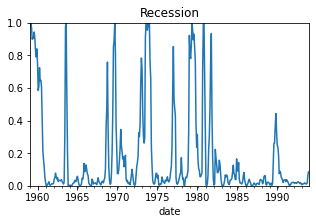

In [168]:
################################################################
####### plot of recession probability
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a new DataFrame to store the ratios
date_range_ratios = pd.date_range(start='1960-01', end='1995-01', freq='M')
df_ratios = pd.DataFrame({'date': date_range_ratios, 'ratio': recession.ravel()})
df_ratios.set_index('date', inplace=True)

# Plot the ratio series
df_ratios['ratio'].plot(title="Recession", figsize=(5, 3))
plt.ylim(0, 1)
ticks = pd.date_range('1960-01-01', '1995-01-01', freq='5Y')
plt.xticks(ticks, ticks.strftime('%Y'))
plt.show()

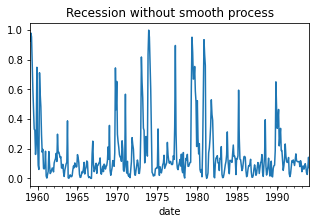

In [169]:
################################################################
####### plot of recession probability (no smooth process)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Create a new DataFrame to store the ratios
date_range_ratios = pd.date_range(start='1960-01', end='1995-01', freq='M')
df_ratios = pd.DataFrame({'date': date_range_ratios, 'ratio':res.filtered_marginal_probabilities[1].ravel()})
df_ratios.set_index('date', inplace=True)

# Plot the ratio series
df_ratios['ratio'].plot(title="Recession without smooth process", figsize=(5, 3))
ticks = pd.date_range('1960-01-01', '1995-01-01', freq='5Y')
plt.xticks(ticks, ticks.strftime('%Y'))
# plt.ylim(0, 1)
plt.show()

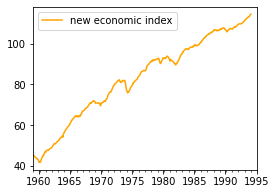

In [170]:
import numpy as np
from numpy.random import normal
N=kalpre.shape[0]
ddelta=np.mean(delta)
C0=40
newCLI = np.zeros((N, 1))
dddelta=np.mean(delta)
newCLI[0]=C0+(sample_ct/(iter-burn))[0]+dddelta
for i in range(1, N):
    newCLI[i] = newCLI[i-1] + (sample_ct/(iter-burn))[i]+dddelta # new delta_C_t=delta_c_t+C_{t-1}+delta according to appendix A7
    # Create an array of monthly dates
newCLI=newCLI[3:N]
dates = pd.date_range(start='1960-01', end='1995-01', freq='MS')

# Create a pandas Series with the data and the dates as index
series1 = pd.Series(data=newCLI.ravel(), index=dates)
fig, ax = plt.subplots(figsize=(5,3))
# Plot the series
series1.plot(figsize=(4,3), legend=False,label='new economic index',color='orange')


# Set the y-axis limits
#ax.set_ylim(30, 120)
plt.legend()
ticks = pd.date_range('1960-01-01', '2000-01-01', freq='5Y')
plt.xticks(ticks, ticks.strftime('%Y'))
plt.show()